# **BERT based Sentiment analysis on Obinrank data agumented with GPT synthatic data**


In [1]:
!pip install torch

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.5 MB/s eta 0:00:00


In [3]:
!pip install transformers

In [4]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00


In [5]:
# import all necessary dependencies
import torch
import optuna
import pandas as pd
import tqdm.notebook as tqdm
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from datasets import Dataset


#**1. Data Preparations 🗃️**

In [28]:
dataframe = pd.read_csv('/content/cleaned_reviews.csv')

In [29]:
dataframe.shape

(2797, 2)

In [30]:
dataframe.head()

,review_text,sentiment
0,this was our first trip to new york so i was u...,Positive
1,stayed nights at the affinia manhatten in a st...,Positive
2,we stayed at the affinia from the rd to the th...,Positive
3,we loved this hotel the room was great we had ...,Positive
4,my teenage daughter and i stayed one night we ...,Positive


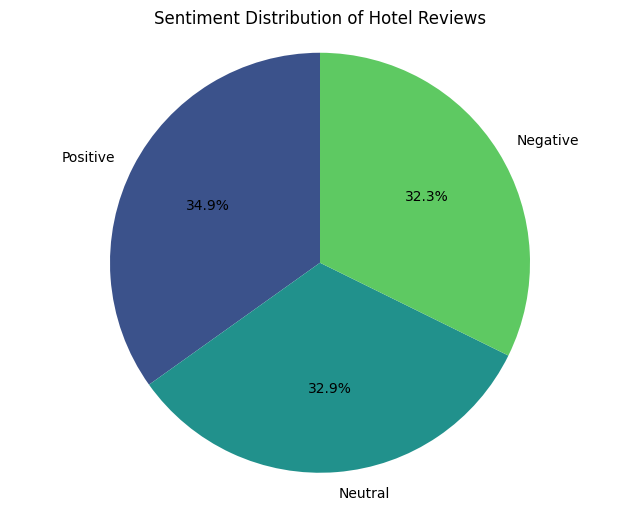

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sentiment_counts = dataframe['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(sentiment_counts)))


plt.title('Sentiment Distribution of Hotel Reviews')
plt.axis('equal')

plt.show()


In [32]:
dataframe['sentiment'].value_counts()

,count
sentiment,
Positive,975
Neutral,919
Negative,903


In [33]:
# convert sentiment labels into numercal values ( label encoding before inputing it into bert)
possible_labels = dataframe['sentiment'].unique()  #list that conatin all-of the labels

label_dict = {} # Creating an empty Dict, & Looping over the possible labels
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

label_dict

{'Positive': 0, 'Negative': 1, 'Neutral': 2}

In [34]:
dataframe['label'] = dataframe['sentiment'].replace(label_dict)

<ipython-input-34-e4145fe528e5>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe['label'] = dataframe['sentiment'].replace(label_dict)


In [35]:
dataframe.head()

,review_text,sentiment,label
0,this was our first trip to new york so i was u...,Positive,0
1,stayed nights at the affinia manhatten in a st...,Positive,0
2,we stayed at the affinia from the rd to the th...,Positive,0
3,we loved this hotel the room was great we had ...,Positive,0
4,my teenage daughter and i stayed one night we ...,Positive,0


In [36]:
from sklearn.model_selection import train_test_split

# First split: Train 60% and Temp (Validation + Test) 40%
train_df, temp_df = train_test_split(dataframe,
                                     test_size=0.4,  # 40% of the dataset for validation + test
                                     stratify=dataframe['label'],# Maintain label distribution
                                     random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Second split: Split Temp into Validation (20%) and Test (20%)
val_df, test_df = train_test_split(temp_df,
                                   test_size=0.5,# 50% of the temp set (40% * 0.5 = 20% of the total data)
                                   stratify=temp_df['label'],# Maintain label distribution
                                   random_state=42)


In [42]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
def tokenize_function(examples):
    return tokenizer(examples['review_text'], padding='max_length', truncation=True)


In [43]:
# Converts the pandas DataFrames into Hugging Face Dataset objects, so it can be used with Trainer
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [44]:
# apply tokenization function to generate word embeddings of each review
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/1678 [00:00<?, ? examples/s]

Map:   0%|          | 0/559 [00:00<?, ? examples/s]

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

In [46]:
#Remove unnecessary columns (cleaned_text and index columns) from the dataset to avoid any issues during training.
train_dataset = train_dataset.remove_columns(['review_text', '__index_level_0__'])
val_dataset = val_dataset.remove_columns(['review_text', '__index_level_0__'])
test_dataset = test_dataset.remove_columns(['review_text', '__index_level_0__'])

In [47]:
#Converts datasets into PyTorch format, making them compatible with BERT (which is typically trained using PyTorch).
train_dataset.set_format('torch')
val_dataset.set_format('torch')
test_dataset.set_format('torch')

#**2. Model Fine-Tuning 🛠️**

In [48]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute Accuracy
    accuracy = accuracy_score(labels, preds)

    # Compute Precision, Recall, F1
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    # Compute Confusion Matrix (optional, for detailed class-wise performance)
    cm = confusion_matrix(labels, preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [49]:
# Objective function for hyperparameter tuning with Optuna
def objective(trial):
    # Define the search space for hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    num_train_epochs = trial.suggest_int("num_train_epochs", 2, 4)
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32])

    # Initialize the model
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

    # Training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        learning_rate=learning_rate,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",   # Evaluate at the end of each epoch
        save_strategy="epoch",         # Save the model at the end of each epoch to match evaluation strategy
        save_total_limit=2,            # Keep only the 2 best models
        load_best_model_at_end=True,   # Load the best model at the end
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate the model on the validation set
    eval_results = trainer.evaluate(val_dataset)

    # Return the evaluation loss as the objective metric
    return eval_results["eval_loss"]

In [50]:
# Run the hyperparameter tuning with Optuna
study = optuna.create_study(direction="minimize")  # Minimize validation loss
study.optimize(objective, n_trials=10)  # Try 10 different hyperparameter configurations

[I 2024-10-24 21:52:29,437] A new study created in memory with name: no-name-4de69e81-39ef-44be-9193-0ba63195d806
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.209000,0.170173,0.994633,0.994643,0.994633,0.994633
2,0.013500,0.014462,0.998211,0.998221,0.998211,0.998211
3,0.002700,0.013631,0.998211,0.998221,0.998211,0.998211


[I 2024-10-24 22:02:33,280] Trial 0 finished with value: 0.013630897738039494 and parameters: {'learning_rate': 1.1727127657504427e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.013630897738039494.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.961200,0.842472,0.663685,0.497341,0.663685,0.557090
2,0.722800,0.655063,0.781753,0.863619,0.781753,0.754025
3,0.489000,0.380690,0.983900,0.983908,0.983900,0.983899


[I 2024-10-24 22:12:21,166] Trial 1 finished with value: 0.38069039583206177 and parameters: {'learning_rate': 1.1286191130701054e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.013630897738039494.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.034000,0.023429,0.998211,0.998221,0.998211,0.998211
2,0.001800,0.005245,0.998211,0.998221,0.998211,0.998211
3,0.000600,0.013551,0.998211,0.998221,0.998211,0.998211
4,0.000500,0.011372,0.998211,0.998221,0.998211,0.998211


[I 2024-10-24 22:25:30,790] Trial 2 finished with value: 0.005244779866188765 and parameters: {'learning_rate': 3.134753795121515e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 8}. Best is trial 2 with value: 0.005244779866188765.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.975000,0.882976,0.713775,0.817759,0.713775,0.649060
2,0.707100,0.615795,0.958855,0.961321,0.958855,0.958744
3,0.444200,0.335377,0.987478,0.987937,0.987478,0.987470
4,0.179400,0.128650,0.998211,0.998221,0.998211,0.998211


[I 2024-10-24 22:38:15,287] Trial 3 finished with value: 0.12864986062049866 and parameters: {'learning_rate': 1.235014468267237e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 0.005244779866188765.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.829900,0.740581,0.810376,0.860876,0.810376,0.796000
2,0.440300,0.310613,0.996422,0.996461,0.996422,0.996422


[I 2024-10-24 22:44:48,207] Trial 4 finished with value: 0.31061261892318726 and parameters: {'learning_rate': 3.184446284152674e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 0.005244779866188765.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.358000,0.265717,0.974955,0.976726,0.974955,0.974908
2,0.005700,0.005069,1.000000,1.000000,1.000000,1.000000


[I 2024-10-24 22:51:42,976] Trial 5 finished with value: 0.005069182254374027 and parameters: {'learning_rate': 1.2729374683427615e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8}. Best is trial 5 with value: 0.005069182254374027.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.264300,0.180915,0.980322,0.981432,0.980322,0.980297
2,0.004200,0.011923,0.998211,0.998221,0.998211,0.998211
3,0.001000,0.010463,0.998211,0.998221,0.998211,0.998211
4,0.000800,0.009931,0.998211,0.998221,0.998211,0.998211


[I 2024-10-24 23:04:41,826] Trial 6 finished with value: 0.009931209497153759 and parameters: {'learning_rate': 1.8207446963542946e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 8}. Best is trial 5 with value: 0.005069182254374027.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.689400,0.585897,0.958855,0.962650,0.958855,0.958691
2,0.119900,0.091102,0.996422,0.996461,0.996422,0.996422


[I 2024-10-24 23:11:12,319] Trial 7 finished with value: 0.0911019966006279 and parameters: {'learning_rate': 1.7091046217701185e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16}. Best is trial 5 with value: 0.005069182254374027.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.612000,0.486628,0.935599,0.943837,0.935599,0.935034
2,0.041800,0.029349,0.996422,0.996422,0.996422,0.996422
3,0.004300,0.005975,0.998211,0.998221,0.998211,0.998211


[I 2024-10-24 23:20:56,721] Trial 8 finished with value: 0.005974939558655024 and parameters: {'learning_rate': 2.627509576612525e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16}. Best is trial 5 with value: 0.005069182254374027.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.368100,0.228301,0.991055,0.991292,0.991055,0.991052
2,0.007100,0.006000,1.000000,1.000000,1.000000,1.000000
3,0.002100,0.003723,0.998211,0.998221,0.998211,0.998211
4,0.009900,0.013631,0.998211,0.998221,0.998211,0.998211


[I 2024-10-24 23:33:23,477] Trial 9 finished with value: 0.0037233305629342794 and parameters: {'learning_rate': 4.837267864524368e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16}. Best is trial 9 with value: 0.0037233305629342794.


In [51]:
# 7. Print best hyperparameters
print("Best hyperparameters:", study.best_params)

Best hyperparameters: {'learning_rate': 4.837267864524368e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16}


In [52]:
# 8. Train the final model with the best hyperparameters
best_params = study.best_params

training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=best_params['learning_rate'],
    num_train_epochs=best_params['num_train_epochs'],
    per_device_train_batch_size=best_params['per_device_train_batch_size'],
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",   # Evaluate at the end of each epoch
    save_strategy="epoch",         # Save the model at the end of each epoch to match evaluation strategy
    save_total_limit=2,            # Keep only the 2 best models
    load_best_model_at_end=True,   # Load the best model at the end
)


# Initialize the model with best hyperparameters
final_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


# Initialize Trainer with the best hyperparameters
trainer = Trainer(
    model=final_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train and save the final model
trainer.train()
trainer.save_model('./best_fine_tuned_bert')
tokenizer.save_pretrained('./best_fine_tuned_bert')

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.242235,0.992844,0.992844,0.992844,0.992844
2,No log,0.003058,1.000000,1.000000,1.000000,1.000000
3,No log,0.001745,1.000000,1.000000,1.000000,1.000000
4,No log,0.001601,1.000000,1.000000,1.000000,1.000000


('./best_fine_tuned_bert/tokenizer_config.json',
 './best_fine_tuned_bert/special_tokens_map.json',
 './best_fine_tuned_bert/vocab.txt',
 './best_fine_tuned_bert/added_tokens.json',
 './best_fine_tuned_bert/tokenizer.json')

#**3. Model Evaluation 🔍**

In [53]:
# 9. Evaluate the final model on the test set
test_results = trainer.evaluate(test_dataset)
print(test_results)

{'eval_loss': 0.0071224370039999485, 'eval_accuracy': 0.9982142857142857, 'eval_precision': 0.9982240973312403, 'eval_recall': 0.9982142857142857, 'eval_f1': 0.9982143125225861, 'eval_runtime': 18.5731, 'eval_samples_per_second': 30.151, 'eval_steps_per_second': 1.884, 'epoch': 4.0}


In [54]:
# Load the best fine-tuned model and tokenizer
model_path = '/content/best_fine_tuned_bert'
tokenizer = BertTokenizerFast.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

# Set the model to evaluation mode
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [56]:
# Example text for inference
texts = [
    "The hotel was amazing and the staff was very friendly!",
    "The room was dirty and the service was terrible."
]

# Tokenize the input text
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Move inputs to the correct device (if using GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
inputs = {key: value.to(device) for key, value in inputs.items()}

In [57]:
# Perform inference
with torch.no_grad():  # Disable gradient computation for inference
    outputs = model(**inputs)
    logits = outputs.logits

# Get the predicted class for each input
predicted_classes = torch.argmax(logits, dim=1)

# Convert predicted class indices to labels (0=Positive, 1=Negative, 2=Neutral)
label_map = {0: "Positive", 1: "Negative", 2: "Neutral"}
predicted_labels = [label_map[pred.item()] for pred in predicted_classes]

# Print results
for text, label in zip(texts, predicted_labels):
    print(f"Text: {text}\nPredicted Sentiment: {label}\n")

Text: The hotel was amazing and the staff was very friendly!
Predicted Sentiment: Neutral

Text: The room was dirty and the service was terrible.
Predicted Sentiment: Negative

